### Data Load

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.pipeline import Pipeline


# Carregar o dataset
df = pd.read_csv("../data/rent.csv")

# Separar features (X) e target (y)
X = df.drop("price", axis=1) 
y = df["price"]

### 5)

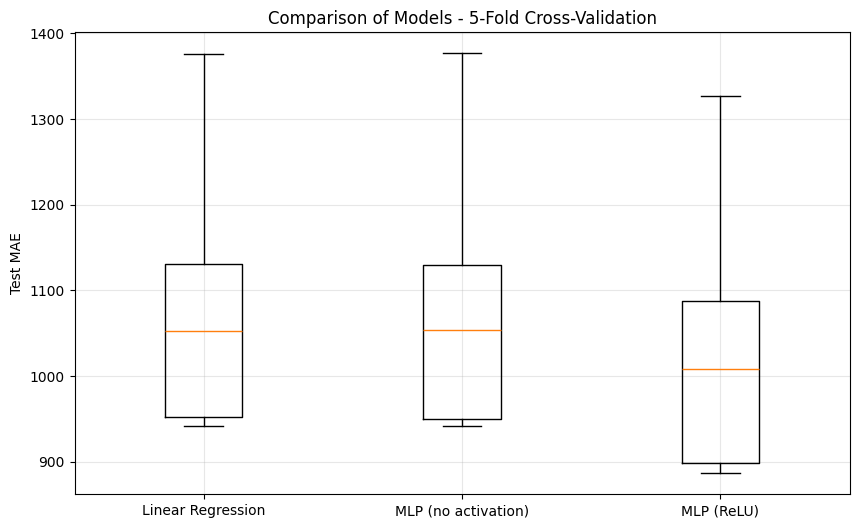

Mean Test MAE:
Linear Regression: 1090.64 +- 158.47
MLP (no activation): 1090.41 +- 159.16
MLP (ReLU): 1041.73 +- 160.82


In [ ]:
warnings.filterwarnings(action="ignore", category=ConvergenceWarning)

# Modelo 1: Regressão Linear
model1 = LinearRegression()

# Modelo 2: MLP sem funções de ativação
model2 = MLPRegressor(
    hidden_layer_sizes=(5, 5),  
    activation="identity",  
    max_iter=1000,
    random_state=42,
)

# Modelo 3: MLP com ReLU
model3 = MLPRegressor(
    hidden_layer_sizes=(5, 5),  
    activation="relu",  
    max_iter=1000,
    random_state=42,
)

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)


# Fazer cross-validation para cada modelo
cv_results1 = cross_validate(
    model1,
    StandardScaler().fit_transform(X),
    y,
    cv=5,
    scoring=mae_scorer,
    return_train_score=True,
)

cv_results2 = cross_validate(
    model2, StandardScaler().fit_transform(X), y, cv=5, scoring=mae_scorer, return_train_score=True
)

cv_results3 = cross_validate(
    model3, StandardScaler().fit_transform(X), y, cv=5, scoring=mae_scorer, return_train_score=True
)


mae1 = -cv_results1["test_score"]
mae2 = -cv_results2["test_score"]
mae3 = -cv_results3["test_score"]

# Preparar os dados para o boxplot
data = [mae1, mae2, mae3]
labels = ["Linear Regression", "MLP (no activation)", "MLP (ReLU)"]

# Criar o boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(data, tick_labels=labels)
plt.ylabel("Test MAE")
plt.title("Comparison of Models - 5-Fold Cross-Validation")
plt.grid(True, alpha=0.3)
plt.show()

print("Mean Test MAE:")
print(f"Linear Regression: {mae1.mean():.2f} +- {mae1.std():.2f}")
print(f"MLP (no activation): {mae2.mean():.2f} +- {mae2.std():.2f}")
print(f"MLP (ReLU): {mae3.mean():.2f} +- {mae3.std():.2f}")

### 6)

The Linear Regression model achieved a mean test MAE of 1090.64 ± 158.47, while the MLP without activation functions performed almost identically, with a mean test MAE of 1090.41 ± 159.16. The MLP with ReLU activation achieved the best performance, with a mean test MAE of 1041.73 ± 160.82.

These results make sense when we consider how neural networks work. An MLP without activation functions is effectively just a linear model, regardless of how many layers it has. This happens because stacking multiple linear transformations still results in a single linear transformation. Therefore, this model cannot learn nonlinear relationships in the data. Its performance being nearly identical to Linear Regression confirms this behavior, as both models are learning similar linear patterns.

The MLP with ReLU activation performs slightly better because the ReLU introduces nonlinearity into the model. This allows it to capture more complex relationships between the input features and rent prices. However, the improvement over Linear Regression is modest, suggesting that the relationship in this dataset is mostly linear. The slightly higher variance in the ReLU model’s results (±160.82 compared to ±158.47) indicates that while it generalizes similarly, it may be a bit more sensitive to the training folds due to its higher model complexity.

### 7)

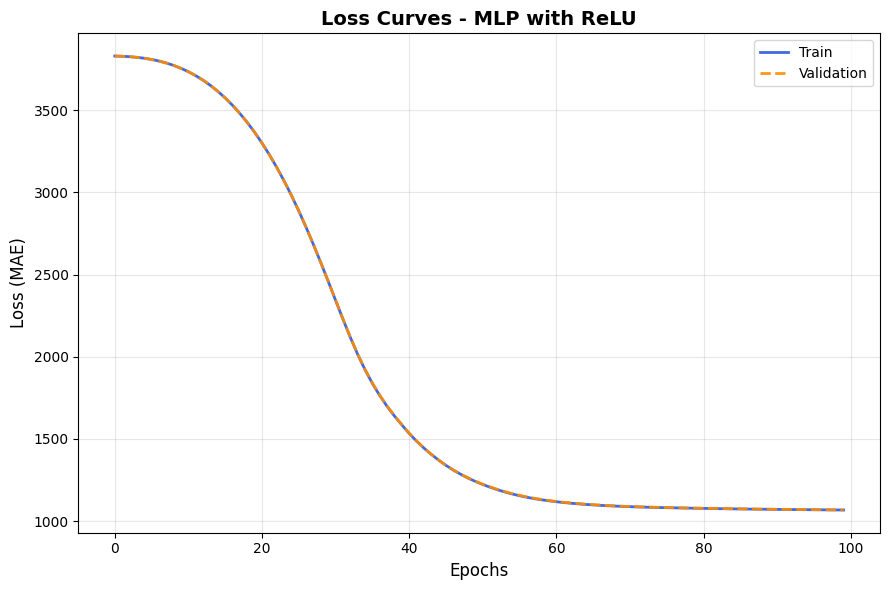

In [7]:
warnings.filterwarnings(action="ignore", category=ConvergenceWarning)

kf = KFold(n_splits=5, shuffle=True, random_state=0)
n_epochs = 100

train_losses = []
val_losses = []

X_array = X.values
y_array = y.values

for train_index, val_index in kf.split(X):
    X_train, X_val = X_array[train_index], X_array[val_index]
    y_train, y_val = y_array[train_index], y_array[val_index]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    train_loss_fold = []
    val_loss_fold = []

    mlp_fold = MLPRegressor(
        hidden_layer_sizes=(5, 5),
        activation="relu",
        max_iter=1,
        warm_start=True,
        random_state=0
    )

    for epoch in range(n_epochs):
        mlp_fold.fit(X_train, y_train)

        y_train_pred = mlp_fold.predict(X_train)
        y_val_pred = mlp_fold.predict(X_val)

        train_loss_fold.append(mean_absolute_error(y_train, y_train_pred))
        val_loss_fold.append(mean_absolute_error(y_val, y_val_pred))

    train_losses.append(train_loss_fold)
    val_losses.append(val_loss_fold)

train_loss_mean = np.mean(train_losses, axis=0)
val_loss_mean = np.mean(val_losses, axis=0)

plt.figure(figsize=(9, 6))

plt.plot(train_loss_mean, label="Train", color="royalblue", linewidth=2)
plt.plot(
    val_loss_mean,
    label="Validation",
    color="darkorange",
    linestyle="--",
    linewidth=2,
    alpha=0.9,
)

plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss (MAE)", fontsize=12)
plt.title("Loss Curves - MLP with ReLU", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The MLP with ReLU activation achieved very similar loss values for training and validation across all epochs. This behaviour and the absence of divergence between the two curves reflects good generalization capacity, as the model fits the data well without overfitting or underfitting.